In [29]:
#Задание 1

#Импортируем библиотеки, которыми будем пользоваться во всех заданиях
import requests
import alpha_vantage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

API_URL = "https://www.alphavantage.co/query"

#Значения параметров для запроса на alphavantage. Вместо apikey был мой apikey
params_apple = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "AAPL",
    "outputsize": "full",
    "datatype": "csv",
    "apikey": ""
    }

params_google = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "GOOG",
    "outputsize": "full",
    "datatype": "csv",
    "apikey": ""
    }

params_facebook = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "FB",
    "outputsize": "full",
    "datatype": "csv",
    "apikey": ""
    }


#Загрузили дневные котировки акций за весь период
res_apple = requests.get(API_URL, params=params_apple)
res_google = requests.get(API_URL, params=params_google)
res_facebook = requests.get(API_URL, params=params_facebook)


#Для дальнейшего удобства записали данные в файлы csv
data_apple = open('data_apple','wb')
data_apple.write(res_apple.content)
data_apple.close()

data_google = open('data_google','wb')
data_google.write(res_google.content)
data_google.close()

data_facebook = open('data_facebook','wb')
data_facebook.write(res_facebook.content)
data_facebook.close()


#Загрузили данные из файлов csv в pandas dataframe
data_apple_full = pd.read_csv('data_apple')
data_google_full = pd.read_csv('data_google')
data_facebook_full = pd.read_csv('data_facebook')


#Выбрали данные за последние 10 лет. Для google/facebook самая ранняя информация позднее 2011-06-20 
data_apple_10 = data_apple_full.drop(data_apple_full[data_apple_full['timestamp'] < '2011-06-20'].index)
data_google_10 = data_google_full.drop(data_google_full[data_google_full['timestamp'] < '2011-06-20'].index)
data_facebook_10 = data_facebook_full.drop(data_facebook_full[data_facebook_full['timestamp'] < '2011-06-20'].index)


#Оставили только столбцы с ценой закрытия
data_apple_10_close = data_apple_10.drop(['open','high','low','volume'],axis=1)
data_google_10_close = data_google_10.drop(['open','high','low','volume'],axis=1)
data_facebook_10_close = data_facebook_10.drop(['open','high','low','volume'],axis=1)

In [33]:
#Задание 2

#Хотим добавить столбец с ценой закрытия следующего дня
#Для последнего дня(2021-06-18) не будем добавлять
#Последний день(2011-06-20/2014-03-27/2012-05-18) не будем учитывать в daily returns
apple_close_next = data_apple_10_close.loc[data_apple_10_close.timestamp>'2011-06-20']
google_close_next = data_google_10_close.loc[data_google_10_close.timestamp>'2014-03-27']
facebook_close_next = data_facebook_10_close.loc[data_facebook_10_close.timestamp>'2012-05-18']


#Удаляем ненужный столбец
apple_close_next = apple_close_next.drop(['timestamp'], axis=1)
google_close_next = google_close_next.drop(['timestamp'], axis=1)
facebook_close_next = facebook_close_next.drop(['timestamp'], axis=1)


#Удаляем день 2021-06-18, нумерацию делаем обычную с 0 
data_apple_10_returns = data_apple_10_close.drop([0]).reset_index(drop=True)
data_google_10_returns = data_google_10_close.drop([0]).reset_index(drop=True)
data_facebook_10_returns = data_facebook_10_close.drop([0]).reset_index(drop=True)


#Добавляем в dataframe data_smth_10_returns информацию о цене закрытия на следующий день
data_apple_10_returns['close_next'] = apple_close_next
data_google_10_returns['close_next'] = google_close_next
data_facebook_10_returns['close_next'] = facebook_close_next


#Вычисляем daily returns, результат записываем в новый столбец
data_apple_10_returns['daily_returns'] = (data_apple_10_returns.close_next-data_apple_10_returns.close)/data_apple_10_returns.close
data_google_10_returns['daily_returns'] = (data_google_10_returns.close_next-data_google_10_returns.close)/data_google_10_returns.close
data_facebook_10_returns['daily_returns'] = (data_facebook_10_returns.close_next-data_facebook_10_returns.close)/data_facebook_10_returns.close


#Удаляем вспомогательные столбцы
data_apple_10_returns = data_apple_10_returns.drop(['close_next','close'], axis=1)
data_google_10_returns = data_google_10_returns.drop(['close_next','close'], axis=1)
data_facebook_10_returns = data_facebook_10_returns.drop(['close_next','close'], axis=1)


#Статистики распределения daily_returns 
statistics_apple_10_returns = data_apple_10_returns.describe()
statistics_google_10_returns = data_google_10_returns.describe()
statistics_facebook_10_returns = data_facebook_10_returns.describe()

<AxesSubplot:>

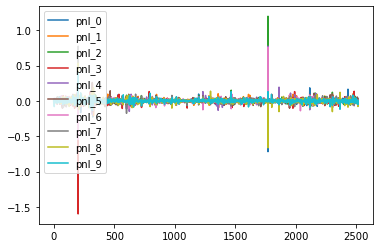

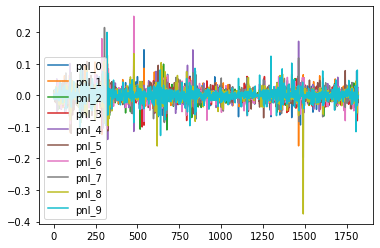

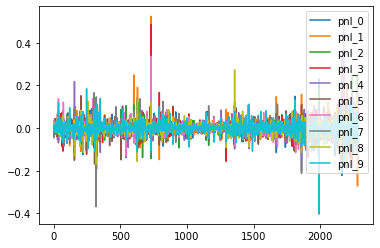

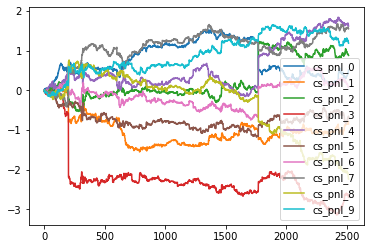

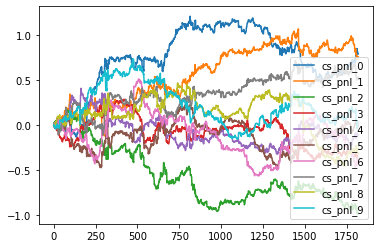

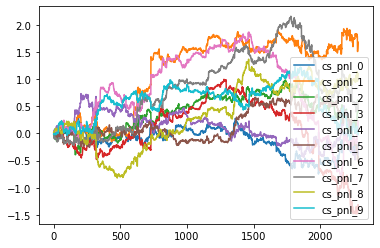

In [52]:
#Задание 3

#В данном задании в качестве нескольких случайных реализаций выберем 10 случайных реализаций
#Все полученные результаты будем сохранять в dataframe smth_pnl
apple_pnl = data_apple_10_returns
google_pnl = data_google_10_returns
facebook_pnl = data_facebook_10_returns


#Генерируем 10 случайных реализаций предсказания f_i
#f_i распределены нормально с mean=0, std=1
#Также добавляем столбцы со значениями profit-and-loss и cumsum(pnl)

for i in range(10):
    apple_pnl['f_'+str(i)] = np.random.normal(0,1,2516)
    apple_pnl['pnl_'+str(i)] = apple_pnl.daily_returns*apple_pnl['f_'+str(i)]
    apple_pnl['cs_pnl_'+str(i)] = apple_pnl['pnl_'+str(i)].cumsum()
    
for i in range(10):
    google_pnl['f_'+str(i)] = np.random.normal(0,1,1820)
    google_pnl['pnl_'+str(i)] = google_pnl.daily_returns*google_pnl['f_'+str(i)]
    google_pnl['cs_pnl_'+str(i)] = google_pnl['pnl_'+str(i)].cumsum()
    
for i in range(10):
    facebook_pnl['f_'+str(i)] = np.random.normal(0,1,2285)
    facebook_pnl['pnl_'+str(i)] = facebook_pnl.daily_returns*facebook_pnl['f_'+str(i)]
    facebook_pnl['cs_pnl_'+str(i)] = facebook_pnl['pnl_'+str(i)].cumsum()
    
    
#Строим графики pnl_i для apple|google|facebook
s = ['pnl_0','pnl_1','pnl_2','pnl_3','pnl_4','pnl_5','pnl_6','pnl_7','pnl_8','pnl_9']
apple_pnl.plot(y=s)
google_pnl.plot(y=s)
facebook_pnl.plot(y=s)


#Строим графики cumsum(pnl_i) для apple|google|facebook
s_cs = ['cs_pnl_0','cs_pnl_1','cs_pnl_2','cs_pnl_3','cs_pnl_4','cs_pnl_5','cs_pnl_6','cs_pnl_7','cs_pnl_8','cs_pnl_9']
apple_pnl.plot(y=s_cs)
google_pnl.plot(y=s_cs)
facebook_pnl.plot(y=s_cs)

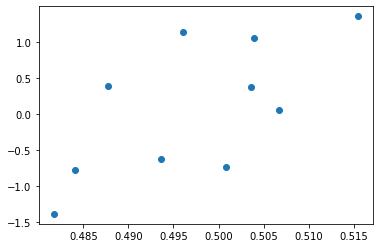

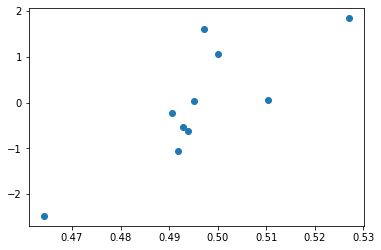

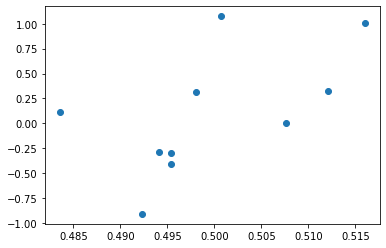

In [82]:
#Задание 4

#Все полученные результаты будем сохранять в dataframe smth_sr
#Значения будем использовать, вычисленные в задании 3
apple_sr = apple_pnl.drop(s_cs,axis=1)
google_sr = google_pnl.drop(s_cs,axis=1)
facebook_sr = facebook_pnl.drop(s_cs,axis=1)


#В списках smth_hit_rate/smth_pnl_mean/smth_pnl_var содержатся hit_rate/mean/var для каждой серии
apple_hit_rate = []
apple_pnl_mean = []
apple_pnl_var = []

google_hit_rate = []
google_pnl_mean = []
google_pnl_var = []

facebook_hit_rate = []
facebook_pnl_mean = []
facebook_pnl_var = []


#Для каждой серии добавляем столбец hit_rate_i, который вычисляет совпадение знака предсказания с return
#Вычисляем значение hit_rate для серии, mean/var для pnl
for i in range(10):
    apple_sr['hit_rate_'+str(i)] = (np.sign(apple_sr.daily_returns) == np.sign(apple_sr['f_'+str(i)])).apply(int)
    apple_hit_rate.append(apple_sr['hit_rate_'+str(i)].sum())
    apple_pnl_mean.append(apple_sr['pnl_'+str(i)].mean())
    apple_pnl_var.append(apple_sr['pnl_'+str(i)].var())
    
for i in range(10):
    google_sr['hit_rate_'+str(i)] = (np.sign(google_sr.daily_returns) == np.sign(google_sr['f_'+str(i)])).apply(int)
    google_hit_rate.append(google_sr['hit_rate_'+str(i)].sum())
    google_pnl_mean.append(google_sr['pnl_'+str(i)].mean())
    google_pnl_var.append(google_sr['pnl_'+str(i)].var())
    
for i in range(10):
    facebook_sr['hit_rate_'+str(i)] = (np.sign(facebook_sr.daily_returns) == np.sign(facebook_sr['f_'+str(i)])).apply(int)
    facebook_hit_rate.append(facebook_sr['hit_rate_'+str(i)].sum())
    facebook_pnl_mean.append(facebook_sr['pnl_'+str(i)].mean())
    facebook_pnl_var.append(facebook_sr['pnl_'+str(i)].var())
    

#Cписки smth_hit_rate/smth_pnl_mean/smth_pnl_var конвертируем в numpy
apple_hit_rate = np.array(apple_hit_rate)
apple_pnl_mean = np.array(apple_pnl_mean)
apple_pnl_var = np.array(apple_pnl_var)
google_hit_rate = np.array(google_hit_rate)
google_pnl_mean = np.array(google_pnl_mean)
google_pnl_var = np.array(google_pnl_var)
facebook_hit_rate = np.array(facebook_hit_rate)
facebook_pnl_mean = np.array(facebook_pnl_mean)
facebook_pnl_var = np.array(facebook_pnl_var)


#Вычисляем коэффициент Шарпа
apple_coef_sr = apple_pnl_mean/apple_pnl_var
google_coef_sr = google_pnl_mean/google_pnl_var
facebook_coef_sr = facebook_pnl_mean/facebook_pnl_var


#Вычисляем hit_rate
apple_hit_rate = apple_hit_rate/2516
google_hit_rate = google_hit_rate/1820
facebook_hit_rate = facebook_hit_rate/2285


#Строим графики scatter plot коэффициента Шарпа от hit_rate
fig,apple = plt.subplots()
apple.scatter(apple_hit_rate, apple_coef_sr)

fig,google = plt.subplots()
google.scatter(google_hit_rate, google_coef_sr) 

fig,facebook = plt.subplots()
facebook.scatter(facebook_hit_rate, facebook_coef_sr) 
plt.show()

In [85]:
#Задание 5

#Данное задание представляет собой задачу бинарной классификации 
#Самыми распространенными методами решения задач такого вида являются регрессия, random forest и нейронные сети
#В связи с ограниченным временем и большим разнообразием нейронных сетей, в данном задании пользоваться ими не будем
#Будем решать данное задание с помощью RandomForest


#Загрузим данные
data = pd.read_csv('xtask.csv')


#Разделим данные на тренировочную и тестовую выборки 
#В исходных данных первые 3070 данных размечены, остальные нет
data_train = data.iloc[:3071]
data_test = data.iloc[3071:].reset_index(drop=True)


#Отделяем признаки и класс для тренировочного множества, и удаляем пустой столбец класса для тестового
X_train = data_train[['a','b','c','d']]
Y_train = data_train['class']
X_test = data_test.drop(['class'],axis=1)


#Будем искать наилучший классификатор с помощью GridSearch
clf_rf = RandomForestClassifier()
parametrs_rf = {'n_estimators':[10,20,30,40,50],'max_depth':range(1,20)}
grid_search_cv_clf_rf = GridSearchCV(clf_rf,parametrs_rf,cv=5)


#Обучим на тренировочных данных с целью нахождения наилучшего классификатора
grid_search_cv_clf_rf.fit(X_train,Y_train)


#Нашли параметры для которых на тренировочных данных лучшая точность
best_clf_rf = grid_search_cv_clf_rf.best_estimator_


#По найденному классификатору предскажем класс для тестового множества
Y_test = best_clf_rf.predict(X_test)


#Запишем полученные результаты в файл
Y_test.tofile('Y_test.csv',sep=',') 